In [177]:
import numpy as np
import scipy.optimize as sc
import matplotlib.pyplot as plt
import time

# 1 (b) Newton's Algorithm - Backtracking Line Search

In [178]:
def rosen(x, a=1, b=100):
    """
    Rosenbrock function definition
    """
    return (a-x[0])**2 + b*((x[1]-x[0]**2)**2)

In [224]:
def rosen_grad(x, a=1, b=100):
    """
    Gradient for Rosenbrock function
    """
    return np.array([2*(x[0]-a)-4*b*x[0]*(x[1]-x[0]**2),
                    2*b*(x[1]-x[0]**2)]).transpose().reshape(-1, 1)

In [244]:
def rosen_hess(x, a=1, b=100):
    """
    Hessian for Rosenbrock function
    """
    return np.array([[12*b*x[0]**2 - 4*b*x[1] + 2, -4*b*x[0]],
                     [-4*b*x[0], 2*b]])

In [254]:
def newton(initial_guess, conc_ratio=0.5, c=10e-4, init_alpha=1.0, stop=10e-8, max_iterations=100):
    """
    Newton's Algorithm
    """
    x = initial_guess
    grad = rosen_grad(x)
    grad_norm = np.linalg.norm(grad)
    i = 0
    true_x = np.array([1.0, 1.0])
    iterates = []
    alphas = []
    rosens = []
    rel_error = []
    while i < max_iterations and grad_norm > stop:
        alpha = init_alpha
        p = -1 * np.matmul(np.linalg.inv(rosen_hess(x)), grad).reshape(2)
        f = rosen(x)
        rhs = f + c*alpha*np.matmul(grad.transpose(),p)
        while rosen(x+alpha*p) > rhs:
            alpha = alpha * conc_ratio
        iterates.append(x)
        alphas.append(alpha)
        rosens.append(f)
        rel_error.append(np.linalg.norm(true_x - x) / np.linalg.norm(true_x))
        x = x + alpha*p
        grad = rosen_grad(x)
        grad_norm = np.linalg.norm(grad)
        i += 1
    
    return iterates, alphas, rosens, rel_error              
        
    

In [281]:
def plot_newton_output(iterates, alphas, rel_error, rosens):
    """
    Plot required values
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    
    # Alpha
    x_axis = [i for i in range(len(iterates))]
    axes[0].plot(x_axis, alphas)
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Alpha (log scale)")
    axes[0].set_ylim(ymin=10e-2)
    axes[0].set_ylim(ymax=5)
    axes[0].minorticks_on()
    axes[0].grid(b=True, which='both', linestyle='-')

    # Iterates
    axes[1].plot(x_axis, rel_error)
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Relative Error (log scale)")
    axes[1].set_ylim(ymin=10e-17)
    axes[1].set_ylim(ymax=10e2)
    axes[1].minorticks_on()
    axes[1].grid(b=True, which='both', linestyle='-')

    # Objective Function
    axes[2].plot(x_axis, rosens)
    axes[2].set_yscale("log")
    axes[2].set_xlabel("Iteration")
    axes[2].set_ylabel("Objective Function (log scale)") 
    axes[2].set_ylim(ymin=10e-10)
    axes[2].set_ylim(ymax=100)
    axes[2].minorticks_on()
    axes[2].grid(b=True, which='both', linestyle='-')

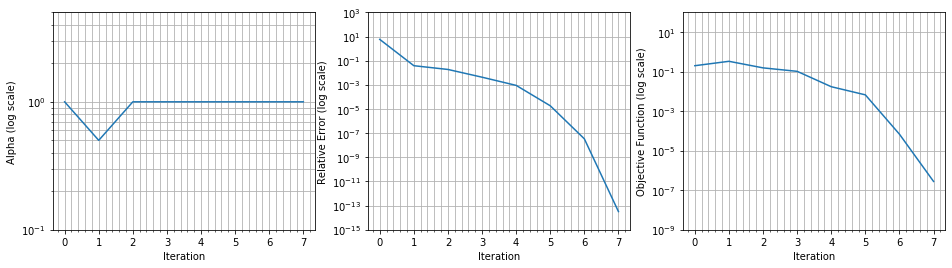

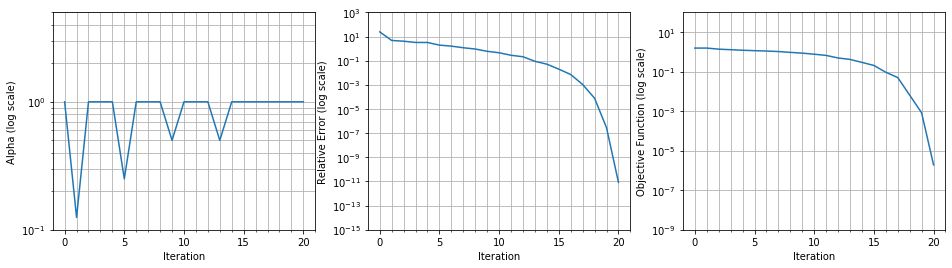

In [275]:
# Run Newton's Method
initial_guess_1 = np.array([1.2, 1.2]).transpose()
initial_guess_2 = np.array([-1.2, 1.0]).transpose()

iterates, alphas, rosens, rel_error = newton(initial_guess_1)
plot_newton_output(iterates, alphas, rosens, rel_error)

iterates, alphas, rosens, rel_error = newton(initial_guess_2)
plot_newton_output(iterates, alphas, rosens, rel_error)


In [276]:
# Run built-in optimizer
res = sc.minimize(rosen, initial_guess_1, method='TNC')
print(res)
res = sc.minimize(rosen, initial_guess_2, method='TNC')
print(res)

     fun: 9.677100838034292e-12
     jac: array([1.75157768e-06, 5.23280656e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 35
     nit: 10
  status: 1
 success: True
       x: array([1.0000031 , 1.00000623])
     fun: 7.14876289130245e-12
     jac: array([1.86593035e-06, 4.73920789e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 81
     nit: 23
  status: 1
 success: True
       x: array([1.00000267, 1.00000535])


In [277]:
# Time measurement

# Backtracking
start=time.process_time()
for i in range(1000):
    newton(initial_guess_1)
end=time.process_time()
print("Backtracking "), print(0.001*(end-start));

# Built-in
start=time.process_time()
for i in range(1000):
    sc.minimize(rosen, initial_guess_1, method='TNC')
end=time.process_time()
print("Built-in "), print(0.001*(end-start));

Backtracking 
0.0004375
Built-in 
0.000546875


# 4 (a) BFGS Method

In [278]:
def bfgs_hessian_update(hess_inv, s, y):
    """
    BFGS update using Sherman-Morrison Formula
    """
    sy = np.matmul(s.transpose(), y)
    yby = np.matmul(y.transpose(), np.matmul(hess_inv, y))
    ss = np.matmul(s, s.transpose())
    bys = np.matmul(hess_inv, np.matmul(y, s.transpose()))
    syb = np.matmul(s, np.matmul(y.transpose(), hess_inv))
    first = (sy + yby) * ss / (sy**2)
    second = (bys + syb) / sy
    return hess_inv + first - second

In [279]:
def bfgs(initial_guess, conc_ratio=0.5, c=10e-4, init_alpha=1.0, stop=10e-8, max_iterations=100):
    """
    BFGS Quasi-Newton Algorithm
    """
    i = 0
    x = initial_guess
    grad = rosen_grad(x)
    grad_norm = np.linalg.norm(grad)
    hess_inv = np.linalg.inv(rosen_hess(x))
    true_x = np.array([1.0, 1.0])
    iterates = []
    alphas = []
    rosens = []
    rel_error = []
    
    while i < max_iterations and grad_norm > stop:
        p = -1 * np.matmul(hess_inv, grad).reshape(2)
        alpha = init_alpha
        f = rosen(x)
        rhs = f + c*alpha*np.matmul(grad.transpose(),p)
        while rosen(x+alpha*p) > rhs:
            alpha = alpha * conc_ratio
        iterates.append(x)
        alphas.append(alpha)
        rosens.append(f)
        rel_error.append(np.linalg.norm(true_x - x) / np.linalg.norm(true_x))
        s = alpha*p.reshape(-1, 1)
        x = x + alpha*p 
        new_grad = rosen_grad(x)
        y = new_grad - grad
        hess_inv = bfgs_hessian_update(hess_inv, s, y)
        grad = new_grad
        grad_norm = np.linalg.norm(grad)
        i += 1
    
    return iterates, alphas, rosens, rel_error

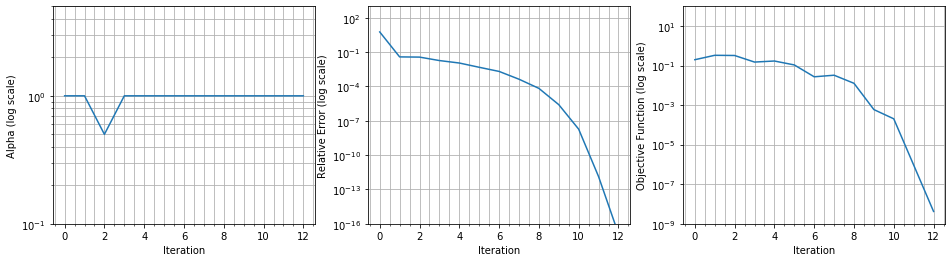

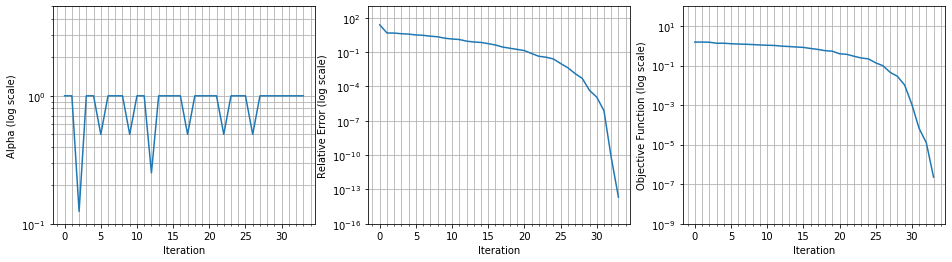

In [282]:
# Run BFGS Method
initial_guess_1 = np.array([1.2, 1.2]).transpose()
initial_guess_2 = np.array([-1.2, 1.0]).transpose()

iterates, alphas, rosens, rel_error = bfgs(initial_guess_1)
plot_newton_output(iterates, alphas, rosens, rel_error)

iterates, alphas, rosens, rel_error = bfgs(initial_guess_2)
plot_newton_output(iterates, alphas, rosens, rel_error)